<a href="https://colab.research.google.com/github/dohuijin/KT-AIVLE-School-4th/blob/main/mini-project7/2_%EC%88%98%EC%96%B4%EB%B2%88%EC%97%AD%EA%B8%B0_%EB%AA%A8%EB%8D%B8%EB%A7%81_%EB%B0%8F_%EC%B6%94%EC%A0%81(%EA%B0%9C%EC%9D%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


!pip install mlflow
import mlflow
import mlflow.keras

In [ ]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/미니프로젝트/7차_ 수어 번역기/data/sign_language.csv')
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [ ]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [ ]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비

In [ ]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* exp4

In [ ]:
exp_id = mlflow.create_experiment("exp4")


## 2 데이터 살펴보기

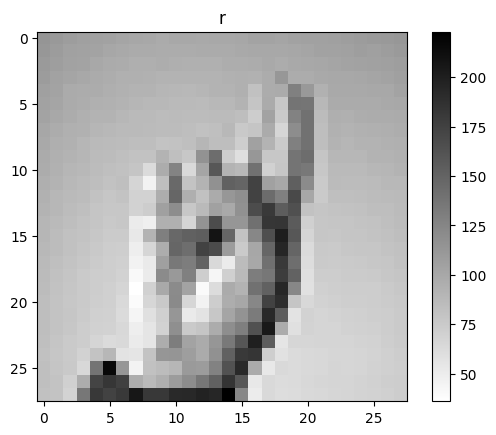

In [ ]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다.
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1)
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [ ]:
x = data.drop('label', axis=1).values
y = data.loc[:, 'label'].values

### (2) 데이터 분할2 : train, validation, test

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=2000, random_state=2023)

In [ ]:
x_train.shape, x_val.shape, x_test.shape

((5000, 784), (2000, 784), (1000, 784))

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

* shape 맞추기 n, 28,28,1
    * reshape
        * x_train.shape : (-1, 28, 28, 1)
        * x_val.shape : (-1, 28, 28, 1)
        * x_test.shape : (-1, 28, 28, 1)

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [ ]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 4.모델링

### (1) 모델1

In [ ]:
with mlflow.start_run(experiment_id=exp_id):
    mlflow.keras.autolog()
    clear_session()

    model = Sequential([Conv2D(16, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides =1, activation='relu'),
                        MaxPooling2D(pool_size=2, strides=2),
                        Flatten(),
                        Dense(128, activation = 'relu'),
                        Dense(26, activation='softmax')
    ])

    model.summary()

    # 컴파일
    model.compile(loss='sparse_categorical_crossentropy',
                metrics=['accuracy'],
                optimizer='adam')
    es = EarlyStopping(
        patience=5,
        min_delta=0,
        verbose=1
    )
    history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=30, batch_size=256, callbacks=[es]).history

    val_pred = model.predict(x_val).argmax(axis=1)
    val_acc = accuracy_score(y_val, val_pred)
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.keras.log_model(model, "keras-model", registered_model_name="DL")
    mlflow.keras.autolog(disable=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               401536    
                                                                 
 dense_1 (Dense)             (None, 26)                3354      
                                                                 
Total params: 405050 (1.55 MB)
Trainable params: 405050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 2s 94ms/step - loss: 2.8854 - accuracy: 0.2540 - val_loss: 2.7064 - val_accuracy: 0.3570
Epoch 3/30
16/16 [==============================] - 2s 142ms/step - loss: 2.5287 - accuracy: 0.3900 - val_loss: 2.3464 - val_accuracy: 0.4060
Epoch 4/30
16/16 [==============================] - 2s 158ms/step - loss: 2.1438 - accuracy: 0.4692 - val_loss: 1.9918 - val_accuracy: 0.4980
Epoch 5/30
16/16 [==============================] - 2s 115ms/step - loss: 1.8230 - accuracy: 0.5480 - val_loss: 1.7205 - val_accuracy: 0.5760
Epoch 6/30
16/16 [==============================] - 2s 92ms/step - loss: 1.5819 - accuracy: 0.5897 - val_loss: 1.5730 - val_accuracy: 0.5480
Epoch 7/30
16/16 [==============================] - 2s 110ms/step - loss: 1.4082 - accuracy: 0.6180 - val_loss: 1.3769 - val_accuracy: 0.6460
Epoch 8/30
16/16 [==============================] - 2s 116ms/step - loss: 1.2686 - accuracy: 0.6593 - val_loss: 1.2454 - val_accuracy: 0.6620
Epoch 9/30
16/16 [=

2024/03/06 06:32:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


63/63 [==============================] - 0s 4ms/step


2024/03/06 06:32:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
Successfully registered model 'DL'.
Created version '1' of model 'DL'.


* 학습곡선

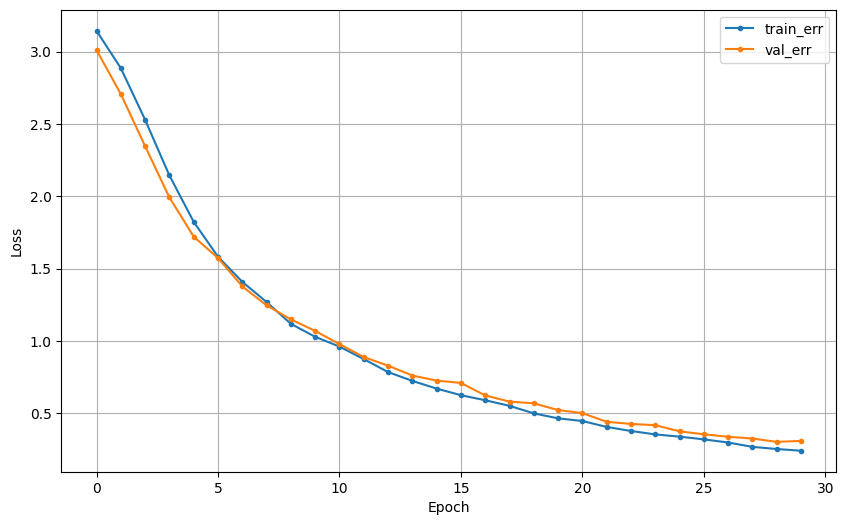

In [ ]:
dl_history_plot(history)

* 예측 및 검증

In [ ]:
y_pred = model.predict(x_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))
print(classification_report(class_names[y_val], class_names[y_pred]))

63/63 [==============================] - 1s 7ms/step
[[80  0  0  0  2  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 96  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 79  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  2  1  0]
 [ 0  0  0  0  0  0 87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  2 62  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0 80  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 96  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 65  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2 79  0  0 

### (2) 모델2

In [ ]:
from keras.layers import BatchNormalization
from keras.models import Model


In [ ]:
with mlflow.start_run(experiment_id=exp_id):
    mlflow.keras.autolog()
    clear_session()

    # 모델 쌓기
    il = Input(shape=(28, 28, 1))

    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(il)
    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(hl)
    hl = BatchNormalization()(hl)
    hl = MaxPooling2D()(hl)
    hl = Dropout(0.2)(hl)

    hl = Conv2D(64, (3, 3), activation='relu', padding='same')(il)
    hl = Conv2D(64, (3, 3), activation='relu', padding='same')(hl)
    hl = BatchNormalization()(hl)
    hl = MaxPooling2D()(hl)
    hl = Dropout(0.2)(hl)

    hl = Flatten()(hl)
    hl = Dense(512, activation='relu')(hl)
    hl = Dropout(0.2)(hl)
    ol = Dense(26, activation='softmax')(hl)

    # 모델 선언
    model = Model(il, ol)

    # 컴파일
    model.compile(loss='sparse_categorical_crossentropy',
                metrics=['accuracy'],
                optimizer='adam')
    es = EarlyStopping(
        patience=5,
        verbose=1
    )
    history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=30, batch_size=64, callbacks=[es]).history

    val_pred = model.predict(x_val).argmax(axis=1)
    val_acc = accuracy_score(y_val, val_pred)
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.keras.log_model(model, "keras-model", registered_model_name="DL")
    mlflow.keras.autolog(disable=True)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 1.4796 - accuracy: 0.5930

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 23s 344ms/step - loss: 1.4796 - accuracy: 0.5930 - val_loss: 2.7291 - val_accuracy: 0.7800
Epoch 2/30
63/63 [==============================] - 24s 375ms/step - loss: 0.1953 - accuracy: 0.9445 - val_loss: 2.2573 - val_accuracy: 0.9610
Epoch 3/30
63/63 [==============================] - 24s 382ms/step - loss: 0.0685 - accuracy: 0.9790 - val_loss: 1.7332 - val_accuracy: 0.8720
Epoch 4/30
63/63 [==============================] - 19s 307ms/step - loss: 0.0227 - accuracy: 0.9942 - val_loss: 1.0711 - val_accuracy: 0.9640
Epoch 5/30
63/63 [==============================] - 19s 299ms/step - loss: 0.0100 - accuracy: 0.9975 - val_loss: 0.6071 - val_accuracy: 0.9940
Epoch 6/30
63/63 [==============================] - 19s 298ms/step - loss: 0.0121 - accuracy: 0.9980 - val_loss: 0.5922 - val_accuracy: 0.8750
Epoch 7/30
63/63 [==============================] - 22s 350ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.1967 - val_accuracy: 0.9760
Epoch 8/30

2024/03/06 06:43:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
Registered model 'DL' already exists. Creating a new version of this model...
Created version '2' of model 'DL'.


* 학습곡선

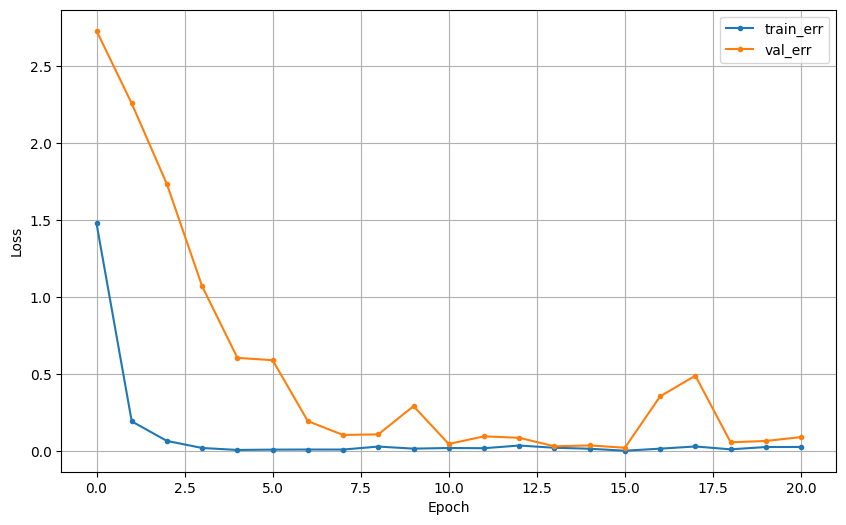

In [ ]:
dl_history_plot(history)

* 예측 및 검증

In [ ]:
y_pred = model.predict(x_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))
print(classification_report(class_names[y_val], class_names[y_pred]))

63/63 [==============================] - 3s 46ms/step
[[87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 91  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  1  0  0  0  0]
 [ 0  1  0  0 74  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 82  0  0  2  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  0  0 83  4  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 73  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 85  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 96  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 69  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0 80  0  0

## 5.모델 사용하기
* 가장 성능이 좋은 모델 production 지정
* Production 모델 호출해서 test 셋으로 예측 및 평가

